# App Rating Predictor
## Building an app rating predictor using data scraped from the android market
### We have scraped some apps from the Google PlayStore, and the primary goals of our project are:
- predict the rating
- predict installation count
- predict whether the app is free or paid 
- predict whether is it ad-supported

But before we start with the explanatory data analysis, we need to do data cleaning/preprocessing because our dataset is VERY UNSTRUCTURED and RAW.

# Table of contents
1. <a href='#feature engineering'>Feature Engineering</a>
2. <a href='#installs EDA'>INSTALLS GROUP EDA</a> 
3. <a href='#miscelleneous EDA'>Miscelleneous EDA</a>
    1. <a href='#singapore EDA'>Singapore EDA</a>
    2. <a href='#fang EDA'>FANG EDA</a>
    3. <a href='#geospatial analysis'>Geospatial Analysis</a>

### Import Neccessary Packages

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sb
sb.set_theme(style="white", palette=None)
pd.set_option("display.max_columns", None) #Show all columns, or else some will just be "..."

import plotly.express as px # shows basic statistics of the figure
from dython import nominal # Use for calculating correlation between variables. Including between categorical and numerical variables
import matplotlib.pyplot as plt # we only need pyplot

import plotly.graph_objects as go # Used as trace for subplots
from plotly.subplots import make_subplots

In [2]:
df = pd.read_csv("./datasets/google_app_scrap_cleaned.csv")
df.head()

APP_NAME    RATING      CATEGORY  RATING_COUNT  \
0  "Ghost Voice Catcher" AUTO EVP  3.933333     Lifestyle            68   
1                          "OXXO"  4.740000        Puzzle           975   
2                          #DRIVE  4.434152        Racing        229679   
3                       #SelfCare  4.463476  Role Playing         14932   
4  #open Polyamorous + ENM Dating  2.550000        Dating           708   

   1_STAR_RATINGS  2_STAR_RATINGS  3_STAR_RATINGS  4_STAR_RATINGS  \
0              12               1               6               7   
1              23               0              15              94   
2            9352            4740           15249           47804   
3             865             336            1088            1353   
4             263             163              63              70   

   5_STAR_RATINGS  REVIEW_COUNT    INSTALLS  MAX_INSTALLS   FREE  PRICE  \
0              42          24.0      1,000+          3608  False   5.99   
1             843          54.0     10,000+         21680  False   0.99   
2          152534        6473.0  5,000,000+       9119244   True   0.00   
3           11290        1501.0  1,000,000+       1209692   True   0.00   
4             149         362.0     50,000+         93463   True   0.00   

          SIZE                DEVELOPER  \
0    1100000.0        BIG BEARD Studios   
1   81000000.0    Hamster On Coke Games   
2  132000000.0  Pixel Perfect Dude S.A.   
3   83000000.0             TRU LUV Inc.   
4   19000000.0                    #open   

                                   DEVELOPER_ADDRESS CONTENT_RATING  \
0                    114 1/2 Ash st. Nashua NH 03060       Everyone   
1  ul Jugosłowiańska 37F/10\r\n73-110 Stargard Sz...       Everyone   
2   ul. Polna 28/6 lok. 4\r\n62-800 Kalisz\r\nPolska       Everyone   
3  186-720 King Street West\r\nToronto, Ontario, ...           Teen   
4                                                NaN     Mature 17+   

   AD_SUPPORTED  IN_APP_PURCHASES  EDITORS_CHOICE  DAYS_SINCE_UPDATE  \
0         False             False           False             1820.0   
1         False             False           False                0.0   
2          True              True           False                4.0   
3         False              True           False              952.0   
4         False              True           False               17.0   

   DAYS_SINCE_RELEASED  
0               3482.0  
1                945.0  
2               1084.0  
3               1275.0  
4               1026.0

# EDA

Before we start our exploratory data analysis, we had split our features into categorical and numerical data

Categorical: `CATEGORY`, `DEVELOPER`, `CONTENT_RATING`, `AD_SUPPORTED`, `IN_APP_PURCHASES`,  `EDITORS_CHOICE`, `FREE`, `COUNTRY`, `INSTALLS`,

Numerical: `DAYS_SINCE_UPDATE`, `DAYS_SINCE_RELEASED`, `RATING`, `RATING_COUNT`, `SIZE`, `PRICE`, `MAX_INSTALLS`, `REVIEW_COUNT`, `1_STAR_RATINGS`, `2_STAR_RATINGS`, `3_STAR_RATINGS`, `4_STAR_RATINGS`, `5_STAR_RATINGS`, 

Some features to note:
1. `APP_NAME` - the values are all unique which indicate the name of the app (useless in model building)
2. `1_STAR_RATINGS`, `2_STAR_RATINGS`, `3_STAR_RATINGS`, `4_STAR_RATINGS`, `5_STAR_RATINGS` - to check the rating count and for visualization purposes
3. `MIN_INSTALLS` - contains the lower bound of the number of installations, it act as a benchmark for `INSTALLS` to tell which category of installs the app falls into 
4. `DEVELOPER_ADDRESS` - we are using `COUNTRY` so we can drop the developer's address
5. `DEVELOPER` - the developer column contains unique values so we can drop them as well
6. `COUNTRY` - for visualization purposes
7. `MAX_INSTALLS` and `INSTALLS` holds the number of installs/installation range of the app, just that `MAX_INSTALLS` is numerical while `INSTALLS` is categorical

Responses to consider:
1. Rating (Numerical)
2. Installs (Cat) 

cat:CATEGORY, CONTENT_RATING, AD_SUPPORTED, IN_APP_PURCHASES,  EDITORS_CHOICE, FREE, INSTALLS, SIZE(turn to cat alr)

num: DAYS_SINCE_UPDATE, DAYS_SINCE_RELEASED, RATING_COUNT, REVIEW_COUNT

In [3]:
df_cleaned = df.copy()
df_cleaned.head()

APP_NAME    RATING      CATEGORY  RATING_COUNT  \
0  "Ghost Voice Catcher" AUTO EVP  3.933333     Lifestyle            68   
1                          "OXXO"  4.740000        Puzzle           975   
2                          #DRIVE  4.434152        Racing        229679   
3                       #SelfCare  4.463476  Role Playing         14932   
4  #open Polyamorous + ENM Dating  2.550000        Dating           708   

   1_STAR_RATINGS  2_STAR_RATINGS  3_STAR_RATINGS  4_STAR_RATINGS  \
0              12               1               6               7   
1              23               0              15              94   
2            9352            4740           15249           47804   
3             865             336            1088            1353   
4             263             163              63              70   

   5_STAR_RATINGS  REVIEW_COUNT    INSTALLS  MAX_INSTALLS   FREE  PRICE  \
0              42          24.0      1,000+          3608  False   5.99   
1             843          54.0     10,000+         21680  False   0.99   
2          152534        6473.0  5,000,000+       9119244   True   0.00   
3           11290        1501.0  1,000,000+       1209692   True   0.00   
4             149         362.0     50,000+         93463   True   0.00   

          SIZE                DEVELOPER  \
0    1100000.0        BIG BEARD Studios   
1   81000000.0    Hamster On Coke Games   
2  132000000.0  Pixel Perfect Dude S.A.   
3   83000000.0             TRU LUV Inc.   
4   19000000.0                    #open   

                                   DEVELOPER_ADDRESS CONTENT_RATING  \
0                    114 1/2 Ash st. Nashua NH 03060       Everyone   
1  ul Jugosłowiańska 37F/10\r\n73-110 Stargard Sz...       Everyone   
2   ul. Polna 28/6 lok. 4\r\n62-800 Kalisz\r\nPolska       Everyone   
3  186-720 King Street West\r\nToronto, Ontario, ...           Teen   
4                                                NaN     Mature 17+   

   AD_SUPPORTED  IN_APP_PURCHASES  EDITORS_CHOICE  DAYS_SINCE_UPDATE  \
0         False             False           False             1820.0   
1         False             False           False                0.0   
2          True              True           False                4.0   
3         False              True           False              952.0   
4         False              True           False               17.0   

   DAYS_SINCE_RELEASED  
0               3482.0  
1                945.0  
2               1084.0  
3               1275.0  
4               1026.0

### Function to find outliers
#### The function below will find the number of outliers and the upper and lower limit. And remove those outliers and return the new dataframe. 

In [4]:
def outliers(frame, col):
    Q1 = frame[col].quantile(0.25)
    Q3 = frame[col].quantile(0.75)
    IQR = Q3-Q1
    upp_lim = Q3 + 1.5*IQR
    low_lim = Q1 - 1.5*IQR    
    count = 0
    for x in frame[col]:
        if ((x > upp_lim) or (x < low_lim)): count += 1;
    print(f"There is {count} outliers in \"{col}\" field.")
    print(f"{col} upper limit: ", upp_lim)
    print(f"{col} lower limit: ", low_lim)
    return frame[frame[col] < upp_lim]

<a id = 'feature engineering'></a>
## Feature Engineering
Before EDA, we will create new fields that we will be using in our EDA and machine learning later on.

### Dealing with `Address`

The raw address of developers might be hard to use for eda, we will generate a new feature `COUNTRY` that holds the country the developer originated.

First, import the dataset of predicted country of each developer address that we generated using **Google Maps API**.

In [5]:
country_df = pd.read_csv("./datasets/developer_country.csv")

# Remove # from each row in DEVELOPER_ADDRESS column to match the format of 
# mapping in the country_df
for i in range(df_cleaned.shape[0]):
    developer_addr = df_cleaned.loc[i, "DEVELOPER_ADDRESS"]
    if (pd.isnull(developer_addr)):
        continue
    df_cleaned.loc[i, "DEVELOPER_ADDRESS"] = developer_addr.replace("#", " ")

# Map to country
df_cleaned['COUNTRY']=df_cleaned[['DEVELOPER_ADDRESS']].merge(country_df,how='left').COUNTRY
    
# Reposition the COUNTRY column
df_cleaned.insert(17, 'COUNTRY', df_cleaned.pop('COUNTRY'))

### Create `SIZEBAND` 

In [6]:
df_cleaned['SIZEBAND'] = "No size band"
df_cleaned.loc[(df_cleaned['SIZE'] <= 10000000), 'SIZEBAND'] = 'very small'
df_cleaned.loc[(df_cleaned['SIZE'] > 10000000) & (df_cleaned['SIZE'] <= 25000000), 'SIZEBAND']   = 'small'
df_cleaned.loc[(df_cleaned['SIZE'] > 25000000) & (df_cleaned['SIZE'] <= 75000000), 'SIZEBAND']   = 'medium'
df_cleaned.loc[(df_cleaned['SIZE'] > 75000000) & (df_cleaned['SIZE'] <= 100000000), 'SIZEBAND']   = 'large'
df_cleaned.loc[(df_cleaned['SIZE'] > 100000000), "SIZEBAND"] = 'very large'
# df_cleaned[['SIZEBAND', 'RATING']].groupby(['SIZEBAND']).mean()

df_cleaned["SIZEBAND"].value_counts()

medium        7675
small         2875
very large    2628
very small    2352
large         1945
Name: SIZEBAND, dtype: int64

### Create `PRICEBAND` 

In [7]:
df_cleaned['PRICEBAND'] = "No Price band"
df_cleaned.loc[ df_cleaned['PRICE'] == 0, 'PRICEBAND'] = 'Free'
df_cleaned.loc[(df_cleaned['PRICE'] > 0) & (df_cleaned['PRICE'] <= 2.99), 'PRICEBAND'] = 'cheap'
df_cleaned.loc[(df_cleaned['PRICE'] > 2.99) & (df_cleaned['PRICE'] <= 4.99), 'PRICEBAND'] = 'normal'
df_cleaned.loc[(df_cleaned['PRICE'] > 4.99) & (df_cleaned['PRICE'] <= 14.99), 'PRICEBAND']   = 'expensive'
df_cleaned.loc[(df_cleaned['PRICE'] > 14.99), 'PRICEBAND']   = 'very expensive'
df_cleaned['PRICEBAND'].value_counts()

Free              13918
cheap              1797
normal              912
expensive           707
very expensive      141
Name: PRICEBAND, dtype: int64

### Edit `CONTENT_RATING` 

In [8]:
df_cleaned['CONTENT_RATING'] = df_cleaned['CONTENT_RATING'].replace('Mature 17+',"Adults")
df_cleaned['CONTENT_RATING'] = df_cleaned['CONTENT_RATING'].replace('Adults only 18+',"Adults")
df_cleaned['CONTENT_RATING'] = df_cleaned['CONTENT_RATING'].replace('Everyone 10+',"Everyone")
df_cleaned["CONTENT_RATING"].value_counts()

Everyone    13662
Teen         2932
Adults        881
Name: CONTENT_RATING, dtype: int64

### Create `DAYS_SINCE_RELEASED_RANGE` 

In [9]:
df_cleaned['DAYS_SINCE_RELEASED_RANGE'] = 'More than 6 months'
df_cleaned.loc[(df_cleaned['DAYS_SINCE_RELEASED'] <= 30), "DAYS_SINCE_RELEASED_RANGE"] = "Within 1 month"
df_cleaned.loc[(df_cleaned['DAYS_SINCE_RELEASED'] > 30) & (df_cleaned['DAYS_SINCE_RELEASED'] <= 30*3), "DAYS_SINCE_RELEASED_RANGE"] = "1 to 3 months"
df_cleaned.loc[(df_cleaned['DAYS_SINCE_RELEASED'] > 30*3) & (df_cleaned['DAYS_SINCE_RELEASED'] <= 30*6), "DAYS_SINCE_RELEASED_RANGE"] = "3 to 6 months"

df_cleaned['DAYS_SINCE_RELEASED_RANGE'].value_counts()

More than 6 months    15927
3 to 6 months           811
1 to 3 months           547
Within 1 month          190
Name: DAYS_SINCE_RELEASED_RANGE, dtype: int64

### Create `DAYS_SINCE_UPDATE_RANGE` 

In [10]:
df_cleaned["DAYS_SINCE_UPDATE"].describe()

count    17475.000000
mean       203.325207
std        412.532359
min          0.000000
25%         11.000000
50%         40.000000
75%        176.000000
max       4004.000000
Name: DAYS_SINCE_UPDATE, dtype: float64

In [11]:
df_cleaned['DAYS_SINCE_UPDATE_RANGE'] = 'More than 6 months'
df_cleaned.loc[(df_cleaned['DAYS_SINCE_UPDATE'] <= 5), "DAYS_SINCE_UPDATE_RANGE"] = "Few days ago"
df_cleaned.loc[(df_cleaned['DAYS_SINCE_UPDATE'] > 5) & (df_cleaned['DAYS_SINCE_UPDATE'] <= 11), "DAYS_SINCE_UPDATE_RANGE"] = "Almost a week"
df_cleaned.loc[(df_cleaned['DAYS_SINCE_UPDATE'] > 11) & (df_cleaned['DAYS_SINCE_UPDATE'] <= 30), "DAYS_SINCE_UPDATE_RANGE"] = "Within 1 month"
df_cleaned.loc[(df_cleaned['DAYS_SINCE_UPDATE'] > 30) & (df_cleaned['DAYS_SINCE_UPDATE'] <= 30*3), "DAYS_SINCE_UPDATE_RANGE"] = "1 to 3 months"
df_cleaned.loc[(df_cleaned['DAYS_SINCE_UPDATE'] > 30*3) & (df_cleaned['DAYS_SINCE_UPDATE'] <= 30*6), "DAYS_SINCE_UPDATE_RANGE"] = "3 to 6 months"

df_cleaned['DAYS_SINCE_UPDATE_RANGE'] .value_counts()

More than 6 months    4305
Within 1 month        3408
1 to 3 months         3274
Few days ago          2610
3 to 6 months         1957
Almost a week         1921
Name: DAYS_SINCE_UPDATE_RANGE, dtype: int64

### Create `REVIEW_RATE`  (review count per day)

In [12]:
df_cleaned["REVIEW_PER_DAY"] = df_cleaned["REVIEW_COUNT"]/df_cleaned["DAYS_SINCE_RELEASED"]
df_cleaned["REVIEW_RATE"] = "More than once per day"
df_cleaned.loc[(df_cleaned['REVIEW_PER_DAY'] <= 0.05), "REVIEW_RATE"] = "Low"
df_cleaned.loc[(df_cleaned['REVIEW_PER_DAY'] > 0.05) & (df_cleaned['REVIEW_PER_DAY'] <= 0.3), "REVIEW_RATE"] = "Medium"
df_cleaned.loc[(df_cleaned['REVIEW_PER_DAY'] > 0.3) & (df_cleaned['REVIEW_PER_DAY'] <= 1), "REVIEW_RATE"] = "High"

df_cleaned["REVIEW_RATE"].value_counts()

More than once per day    7024
Medium                    4097
Low                       3257
High                      3097
Name: REVIEW_RATE, dtype: int64

### Create `RATING_RATE` (rating count per day)

In [13]:
df_cleaned["RATING_PER_DAY"] = df_cleaned["RATING_COUNT"]/df_cleaned["DAYS_SINCE_RELEASED"]
df_cleaned["RATING_PER_DAY"].describe()

count    17475.000000
mean       144.203127
std       1233.382789
min          0.001470
25%          0.823430
50%          7.263251
75%         53.188237
max      93419.044643
Name: RATING_PER_DAY, dtype: float64

In [14]:
df_cleaned["RATING_PER_DAY"] = df_cleaned["RATING_COUNT"]/df_cleaned["DAYS_SINCE_RELEASED"]
df_cleaned["RATING_RATE"] = "More than 50 per day"
df_cleaned.loc[(df_cleaned['RATING_PER_DAY'] <= 1), "RATING_RATE"] = "Low"
df_cleaned.loc[(df_cleaned['RATING_PER_DAY'] > 1) & (df_cleaned['RATING_PER_DAY'] <= 10), "RATING_RATE"] = "Medium"
df_cleaned.loc[(df_cleaned['RATING_PER_DAY'] > 10) & (df_cleaned['RATING_PER_DAY'] <= 50), "RATING_RATE"] = "High"

df_cleaned["RATING_RATE"].value_counts()

Medium                  4747
Low                     4724
More than 50 per day    4502
High                    3502
Name: RATING_RATE, dtype: int64

### Create `INSTALLS GROUP`

In [15]:
df_cleaned['INSTALLS_GROUP'] = 'More than 10M'
df_cleaned.loc[(df_cleaned['INSTALLS'] == '1+') | (df_cleaned['INSTALLS'] == '10+') | (df_cleaned['INSTALLS'] == '50+') | 
       (df_cleaned['INSTALLS'] == '100+') | (df_cleaned['INSTALLS'] == '500+' ) | (df_cleaned['INSTALLS'] == '1,000+' ) | 
       (df_cleaned['INSTALLS'] == '5,000+' ) | (df_cleaned['INSTALLS'] == '10,000+') | (df_cleaned['INSTALLS'] == '50,000+'), 'INSTALLS_GROUP'] = 'Less than 100K'

df_cleaned.loc[ (df_cleaned['INSTALLS'] == '100,000+') | (df_cleaned['INSTALLS'] == '500,000+') | (df_cleaned['INSTALLS'] == '1,000,000+') |
                (df_cleaned['INSTALLS'] == '5,000,000+')
               ,"INSTALLS_GROUP"] = 'Between 100K and 10M'

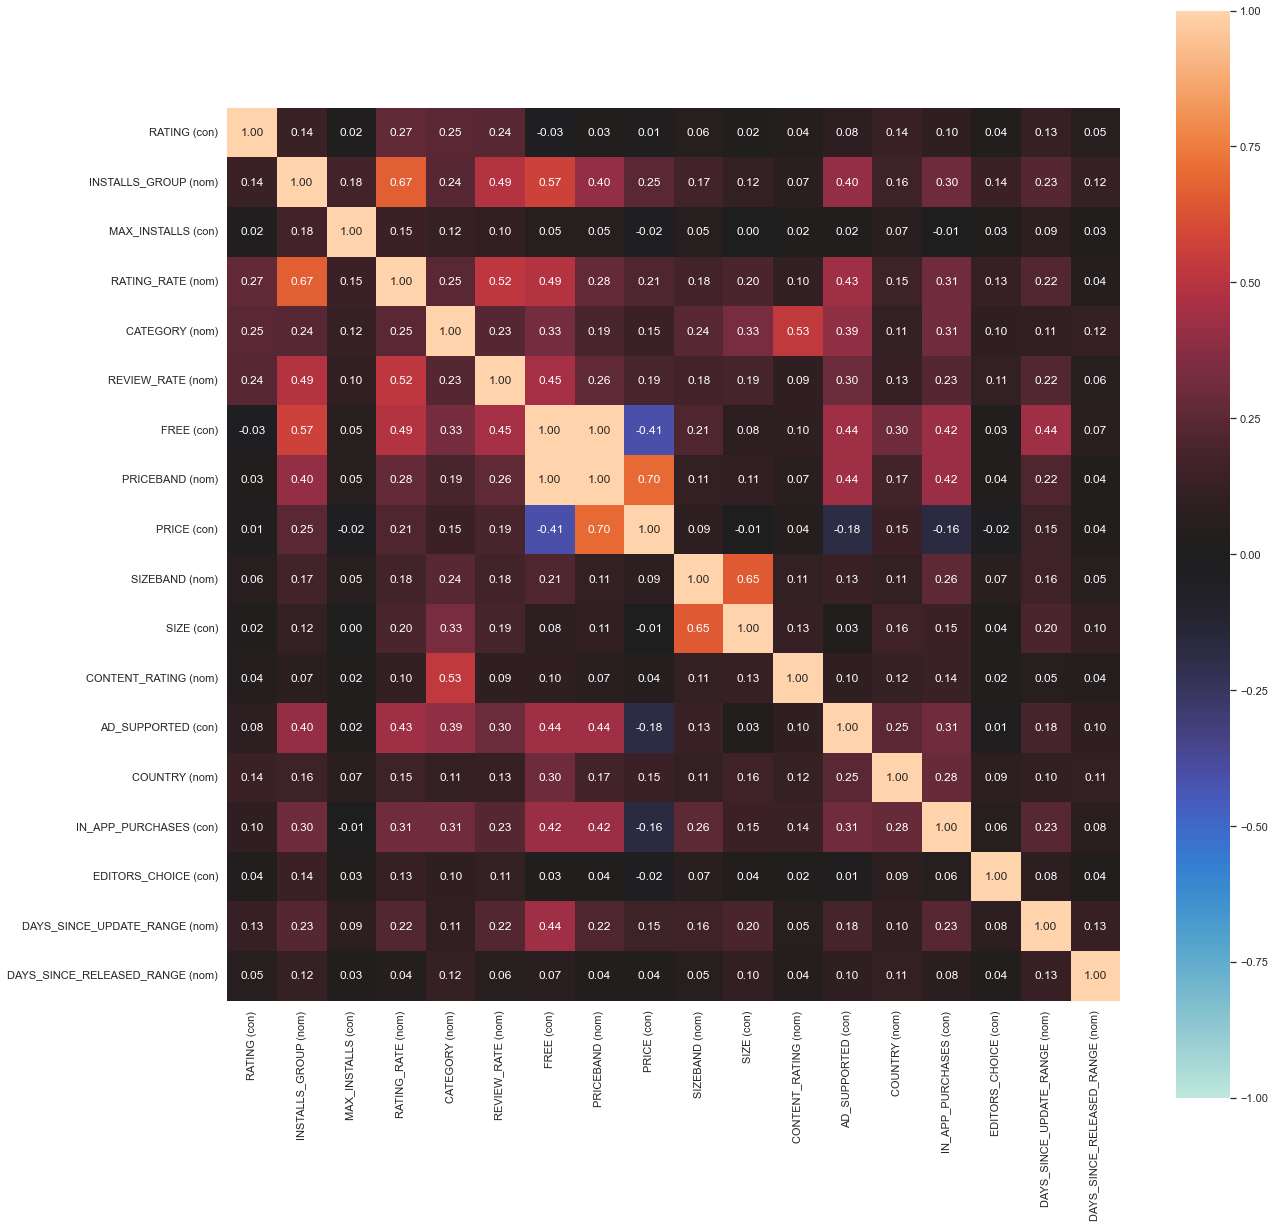

In [16]:
jointDf = df_cleaned[['RATING', 'INSTALLS_GROUP', 'MAX_INSTALLS', 'RATING_RATE', 'CATEGORY', 'REVIEW_RATE', 'FREE', 'PRICEBAND', 'PRICE', 'SIZEBAND', 'SIZE', 'CONTENT_RATING', 'AD_SUPPORTED', 'COUNTRY', 'IN_APP_PURCHASES', 'EDITORS_CHOICE', 'DAYS_SINCE_UPDATE_RANGE', 'DAYS_SINCE_RELEASED_RANGE']]
nominal.associations(jointDf, figsize = (20, 20), mark_columns=True);

We change some numerical variable to categorical because we wanted to **improve the signal-to-noise ratio**. Fitting a model to bins reduces the impact that small fluctuates in the data has on the model. Each bin **minimize the noises** in sections of the data.<br>
For example: 
- INSTALLS_GROUP(categorical) has higher association value than MAX_INSTALLS(numerical)
- PRICEBAND(categorical) has higher association value than PRICE(numerical)
- SIZEBAND(categorical) has higher association value than SIZE(numerical)

---

This heat map shows the correlation between all the variables. Since our problem statement focuses on rating and installs, we focus only on row 1 and 2.

For row 1 (rating), most of the the correlation of the different variables is quite close to 0, with 0.27 being the highest, which is category. 

Next, we move on to installs group which is row 2. We can see that the overall correlations are higher.

Since there is not much of a strong relationship for rating, it might be too challenging to predict the rating of an app since the accuracy would not be high. In this case, we will only do EDA on INSTALLS_GROUP.

---

Dython will automatically find which features are categorical and which are numerical, compute a relevant measure of association between each and every feature, and plot it all as an easy-to-read heat-map.
It will then calculate the correlation/strength-of-association of features in data-set with both categorical and continuous features.

---

<a id = 'installs EDA'></a>
## `INSTALLS_GROUP` EDA

### What is Google Play Store's installation count's distribution?

In [17]:
df_cleaned['INSTALLS_GROUP'] .value_counts()

Between 100K and 10M    9044
Less than 100K          5023
More than 10M           3408
Name: INSTALLS_GROUP, dtype: int64

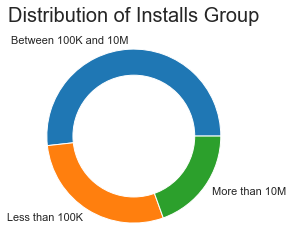

In [18]:
label = df_cleaned['INSTALLS_GROUP'].value_counts().index.tolist()
plt.pie(x = df_cleaned['INSTALLS_GROUP'].value_counts().to_frame().INSTALLS_GROUP, labels = label)
my_circle=plt.Circle((0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Distribution of Installs Group", size =20)
plt.show()

Almost half the number of apps have installs between 100,000 and 10,000,000.

### `INSTALLS_GROUP` VS `EDITORS_CHOICE`

Percentage of apps that are awarded Editors's Choice in each install group:
Between 100K and 10M : 1.02 %
Less than 100K : 0.10 %
More than 10M : 4.93 %


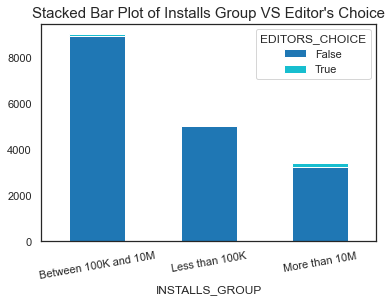

In [19]:
order = df_cleaned['INSTALLS_GROUP'].value_counts().index.tolist()
print('Percentage of apps that are awarded Editors\'s Choice in each install group:')
for i in order:
    print(i,":","%.2f" %(100*
          len(df_cleaned.loc[(df_cleaned['INSTALLS_GROUP'] == i) & (df_cleaned['EDITORS_CHOICE'] == True)])/
          (len(df_cleaned.loc[(df_cleaned['INSTALLS_GROUP'] == i) & (df_cleaned['EDITORS_CHOICE'] == True)])+
           len(df_cleaned.loc[(df_cleaned['INSTALLS_GROUP'] == i) & (df_cleaned['EDITORS_CHOICE'] == False)]))),"%")
cross_tab2 = pd.crosstab(index=df_cleaned['INSTALLS_GROUP'], columns=df_cleaned['EDITORS_CHOICE'])
cross_tab2.loc[order].plot(kind='bar', 
                           stacked=True, 
                           colormap='tab10')
plt.xticks(rotation = 10)
plt.title("Stacked Bar Plot of Installs Group VS Editor\'s Choice", size = 15)
plt.show()

Most of the app are not awarded with 'Editor's Choice'. But there's a slight increase in the likeliness of an app being an 'Editor's Choice' app if they have more installs.

### `INSTALLS_GROUP` VS `FREE`

Percentage of apps that are free in each install group:
Between 100K and 10M : 91.76 %
Less than 100K : 44.08 %
More than 10M : 99.91 %


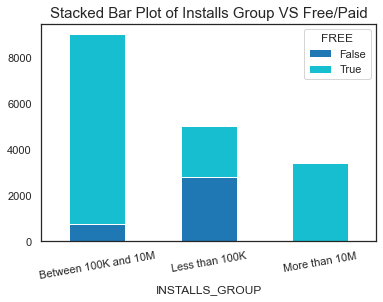

In [20]:
order = df_cleaned['INSTALLS_GROUP'].value_counts().index.tolist()
print('Percentage of apps that are free in each install group:')
for i in order:
    print(i,":","%.2f" %(100*
          len(df_cleaned.loc[(df_cleaned['INSTALLS_GROUP'] == i) & (df_cleaned['FREE'] == True)])/
          (len(df_cleaned.loc[(df_cleaned['INSTALLS_GROUP'] == i) & (df_cleaned['FREE'] == True)])+
           len(df_cleaned.loc[(df_cleaned['INSTALLS_GROUP'] == i) & (df_cleaned['FREE'] == False)]))),"%")
cross_tab2 = pd.crosstab(index=df_cleaned['INSTALLS_GROUP'], columns=df_cleaned['FREE'])
cross_tab2.loc[order].plot(kind='bar', 
                           stacked=True, 
                           colormap='tab10')
plt.xticks(rotation = 10)
plt.title("Stacked Bar Plot of Installs Group VS Free/Paid", size = 15)
plt.show()

Apps that has more than 100K of installs are more likely to be free. Apps that has less installs are less likely to be free majority of players don't play paid games. If an app is paid, it's more likely to have less than 100K of installs.

### `INSTALLS_GROUP` VS `AD_SUPPORTED`

Percentage of apps that have advertisement in each install group:
Between 100K and 10M : 55.23 %
Less than 100K : 20.53 %
More than 10M : 76.58 %


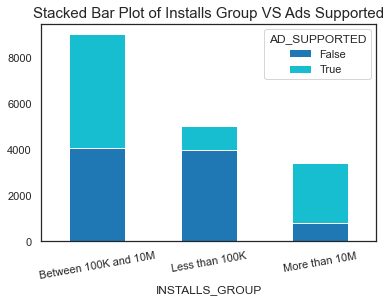

In [21]:
order = df_cleaned['INSTALLS_GROUP'].value_counts().index.tolist()
print('Percentage of apps that have advertisement in each install group:')
for i in order:
    print(i,":","%.2f" %(100*
          len(df_cleaned.loc[(df_cleaned['INSTALLS_GROUP'] == i) & (df_cleaned['AD_SUPPORTED'] == True)])/
          (len(df_cleaned.loc[(df_cleaned['INSTALLS_GROUP'] == i) & (df_cleaned['AD_SUPPORTED'] == True)])+
           len(df_cleaned.loc[(df_cleaned['INSTALLS_GROUP'] == i) & (df_cleaned['AD_SUPPORTED'] == False)]))),"%")
cross_tab2 = pd.crosstab(index=df_cleaned['INSTALLS_GROUP'], columns=df_cleaned['AD_SUPPORTED'])
cross_tab2.loc[order].plot(kind='bar', 
                           stacked=True, 
                           colormap='tab10')
plt.xticks(rotation = 10)
plt.title("Stacked Bar Plot of Installs Group VS Ads Supported", size = 15)
plt.show()

Apps that has more than 100K of installs are more likely to be ad-supported as the developer company might need a source of income to maintain the company and game. 

### `INSTALLS_GROUP` VS `IN_APP_PURCHASES`

Percentage of apps that have in app purchases in each install group:
Between 100K and 10M : 63.11 %
Less than 100K : 36.37 %
More than 10M : 76.56 %


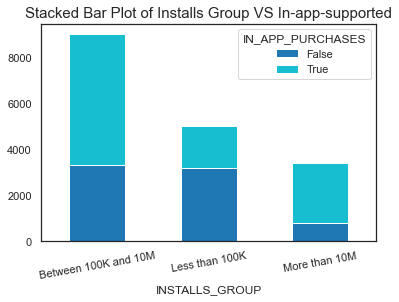

In [22]:
order = df_cleaned['INSTALLS_GROUP'].value_counts().index.tolist()
print('Percentage of apps that have in app purchases in each install group:')
for i in order:
    print(i,":","%.2f" %(100*
          len(df_cleaned.loc[(df_cleaned['INSTALLS_GROUP'] == i) & (df_cleaned['IN_APP_PURCHASES'] == True)])/
          (len(df_cleaned.loc[(df_cleaned['INSTALLS_GROUP'] == i) & (df_cleaned['IN_APP_PURCHASES'] == True)])+
           len(df_cleaned.loc[(df_cleaned['INSTALLS_GROUP'] == i) & (df_cleaned['IN_APP_PURCHASES'] == False)]))),"%")
cross_tab2 = pd.crosstab(index=df_cleaned['INSTALLS_GROUP'], columns=df_cleaned['IN_APP_PURCHASES'])
cross_tab2.loc[order].plot(kind='bar', 
                           stacked=True, 
                           colormap='tab10')
plt.xticks(rotation = 10)
plt.title("Stacked Bar Plot of Installs Group VS In-app-supported", size = 15)
plt.show()

It's quite common to have in app purchases for games that are popular. Apps with higher traction (more installs) will plan to make profit through in app purchases.

### `INSTALLS_GROUP` VS `CONTENT_RATING`

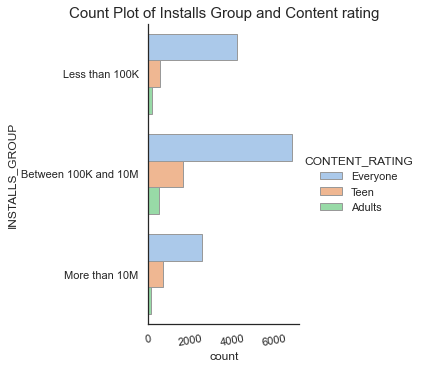

In [23]:
#cross_tab2 = pd.crosstab(index=df_cleaned['INSTALLS_GROUP'], columns=df_cleaned['CONTENT_RATING'])
#cross_tab2.loc[order].plot(kind='bar', 
#                          stacked=True, 
#                         colormap='tab10')
sb.catplot(y="INSTALLS_GROUP", hue="CONTENT_RATING", kind="count",
            palette="pastel", edgecolor=".6",
            data=df_cleaned)
plt.xticks(rotation = 10)
plt.title("Count Plot of Installs Group and Content rating", size = 15)
plt.show()

Most of the app in this dataset are for everyone. And 'Adults' apps are significantly low in all install groups.

### `INSTALLS_GROUP` VS `DAYS_SINCE_UPDATE`

In [24]:
fig = px.histogram(df_cleaned, x="DAYS_SINCE_UPDATE_RANGE", title='Distribution of Days Since Last Update of Apps').update_xaxes(categoryorder = "total descending")
fig.update_layout(
    width=600,
    height=500
)
fig.show()

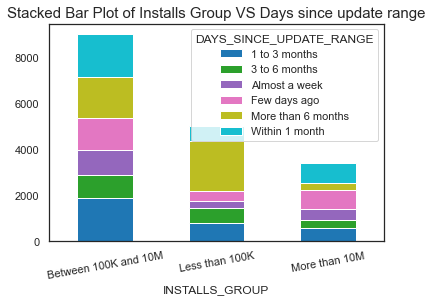

In [25]:
cross_tab2 = pd.crosstab(index=df_cleaned['INSTALLS_GROUP'], columns=df_cleaned['DAYS_SINCE_UPDATE_RANGE'])
cross_tab2.loc[order].plot(kind='bar', 
                           stacked=True, 
                           colormap='tab10')
plt.xticks(rotation = 10)
plt.title("Stacked Bar Plot of Installs Group VS Days since update range", size = 15)
plt.show()

Apps with less than 100K of installs typically are less updated. As the last update is like more than 6 months ago.<br>For apps with more than 100K installs, it's more frequently updated.<br>Especially for apps more than 10M of installs, they are updated few days ago, or at most within 1 month ago.

### `INSTALLS_GROUP` VS `REVIEW_COUNT`

In [26]:
temp = outliers(df_cleaned, "REVIEW_COUNT")

There is 2723 outliers in "REVIEW_COUNT" field.
REVIEW_COUNT upper limit:  8073.75
REVIEW_COUNT lower limit:  -4732.25


In [27]:
fig1 = go.Box(x = df_cleaned["REVIEW_COUNT"], y = df_cleaned["INSTALLS_GROUP"], orientation = "h")
fig2 = go.Box(x = temp["REVIEW_COUNT"], y = temp["INSTALLS_GROUP"], orientation = "h")
fig = make_subplots(rows = 2, cols = 1, subplot_titles=("Box Plot of Installs Group VS Review Count",
                                                        "Box Plot of Installs Group VS Review Count(Outliers Removed)"))
fig.add_trace(fig1, row=1, col=1)
fig.add_trace(fig2, row=2, col=1)
fig.update_layout(
    width=600,
    height=500
)

There's a significant increase in installs as the apps get more review count. <br> For apps that fall into "More than 10M" reviews, they have better tendency toward the center and are less spread out.<br> Compared to apps that have reviews "less than 100K", the values are scattered across the axis.

### `INSTALLS_GROUP` VS `SIZE`

In [28]:
temp2 = outliers(df_cleaned, "SIZE")

There is 692 outliers in "SIZE" field.
SIZE upper limit:  165000000.0
SIZE lower limit:  -67000000.0


In [29]:
fig1 = go.Box(x = df_cleaned["SIZE"], y = df_cleaned["INSTALLS_GROUP"], orientation = "h")
fig2 = go.Box(x = temp2["SIZE"], y = temp2["INSTALLS_GROUP"], orientation = "h")
fig = make_subplots(rows = 2, cols = 1, subplot_titles=("Box Plot of Installs Group VS Size",
                                                        "Box Plot of Installs Group VS Size(Outliers Removed)"))
fig.add_trace(fig1, row=1, col=1)
fig.add_trace(fig2, row=2, col=1)
fig.update_layout(
    width=600,
    height=500
)

Before removing outliers, the figure squeezed on the left side (positively skewed). <br>
After removing outliers, we can observe the size distribution better.

---

Apps with more than 100K of installs requires a greater amount of space (generally). But apps with less than 100K installs have alot of outliers in terms of their size. 

### `INSTALLS_GROUP` VS `CATEGORY`

In [30]:
df_cleaned["CATEGORY"].unique()

array(['Lifestyle', 'Puzzle', 'Racing', 'Role Playing', 'Dating',
       'Beauty', 'Books & Reference', 'Video Players & Editors', 'Tools',
       'Communication', 'Simulation', 'Trivia', 'Entertainment',
       'Libraries & Demo', 'Personalization', 'Finance', 'Education',
       'News & Magazines', 'Music & Audio', 'Card', 'Travel & Local',
       'Social', 'Medical', 'Strategy', 'Arcade', 'Photography', 'Board',
       'Productivity', 'Weather', 'Health & Fitness', 'Business',
       'Action', 'Comics', 'Events', 'Casual', 'Shopping', 'Parenting',
       'Maps & Navigation', 'Sports', 'House & Home', 'Art & Design',
       'Word', 'Casino', 'Food & Drink', 'Adventure', 'Music',
       'Auto & Vehicles', 'Educational'], dtype=object)

Before we start to analyse CATEGORY, there are 17 categories that are considered as games, this info is gotten from the app scraper, we will identify them first.

In [31]:
games_categories = ["Puzzle", "Racing", "Role Playing", "Simulation", "Trivia", "Card", "Strategy", 
                    "Arcade", "Action", "Word", "Casino", "Adventure", "Educational", "Sports", "Board", 
                    "Casual", "Music"]
for i in range(len(df_cleaned)):
    if (df_cleaned.loc[i, "CATEGORY"] in games_categories):
        df_cleaned.loc[i, "CATEGORY"] = "Game"

### What are the most populated app in Google PlayStore?

In [32]:
fig = px.histogram(df_cleaned, x="CATEGORY", title='Distribution of Category').update_xaxes(categoryorder = "total descending")
fig.update_layout(
    width=600,
    height=500
)
fig.show()

Game is highly saturated in this dataset. We will make some conversions later  during model building.

### Performance for each `CATEGORY`

In [33]:
fig = px.box(df_cleaned, x = "INSTALLS", color = "CATEGORY")
fig.update_layout(
    width=600,
    height=600,
    paper_bgcolor="LightSteelBlue",
    title="INSTALLS ACROSS CATEGORY"
)
fig.show()

### Export the files

In [34]:
# exporting the latest data into a csv file
file_path = "./datasets/google_app_scrap_cleaned2.csv"
df_cleaned.to_csv(path_or_buf=file_path, index=False);

In [35]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17475 entries, 0 to 17474
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   APP_NAME                   17475 non-null  object 
 1   RATING                     17475 non-null  float64
 2   CATEGORY                   17475 non-null  object 
 3   RATING_COUNT               17475 non-null  int64  
 4   1_STAR_RATINGS             17475 non-null  int64  
 5   2_STAR_RATINGS             17475 non-null  int64  
 6   3_STAR_RATINGS             17475 non-null  int64  
 7   4_STAR_RATINGS             17475 non-null  int64  
 8   5_STAR_RATINGS             17475 non-null  int64  
 9   REVIEW_COUNT               17475 non-null  float64
 10  INSTALLS                   17475 non-null  object 
 11  MAX_INSTALLS               17475 non-null  int64  
 12  FREE                       17475 non-null  bool   
 13  PRICE                      17475 non-null  flo

<a id='miscelleneous EDA'></a>
# Miscelleneous EDA
---
This part is about exploring the dataset even further through interesting perspectives  but it won't relate to the machine learning later.

---
<a id='singapore EDA'></a>
## Singapore EDA

In [36]:
df_cleaned = df.copy()
country_df = pd.read_csv("./datasets/developer_country.csv")

# Remove # from each row in DEVELOPER_ADDRESS column to match the format of 
# mapping in the country_df
for i in range(df_cleaned.shape[0]):
    developer_addr = df_cleaned.loc[i, "DEVELOPER_ADDRESS"]
    if (pd.isnull(developer_addr)):
        continue
    df_cleaned.loc[i, "DEVELOPER_ADDRESS"] = developer_addr.replace("#", " ")

# Map to country
df_cleaned['COUNTRY']=df_cleaned[['DEVELOPER_ADDRESS']].merge(country_df,how='left').COUNTRY
    
# Reposition the COUNTRY column
df_cleaned.insert(17, 'COUNTRY', df_cleaned.pop('COUNTRY'))


In [37]:
sg = df_cleaned.loc[df_cleaned['COUNTRY'] == 'Singapore']
sg

APP_NAME    RATING           CATEGORY  \
36     1942 🚀 Free classic shooting games  4.587898             Arcade   
37         1945 Air Force: Airplane games  4.698587             Arcade   
72          2nd phone number - call & sms  3.250000      Communication   
118                456 Survival Challenge  4.197674             Action   
123            4Fun Lite - Live Chat Room  4.100000             Social   
...                                   ...       ...                ...   
16694       X Icon Changer - Change Icons  4.205725    Personalization   
16849                               Yugto  4.630769  Books & Reference   
16931        Zombie War Idle Defense Game  4.448276             Casual   
17131            iQIYI-Drama, Anime, Show  4.456103      Entertainment   
17386                     مسابقة الإسلامي  4.437500             Trivia   

       RATING_COUNT  1_STAR_RATINGS  2_STAR_RATINGS  3_STAR_RATINGS  \
36            73531            3418            1592            3184   
37          1952163           48977           19288           61575   
72            13226            5031             648               0   
118           70831            8599            2741            4022   
123           40144            7953               0             757   
...             ...             ...             ...             ...   
16694        367342           44198           11220           19599   
16849         53165            1227             395            3057   
16931         38747            3435            1145            1336   
17131        829479           82545           15040           18621   
17386          1863             116               0             233   

       4_STAR_RATINGS  5_STAR_RATINGS  REVIEW_COUNT      INSTALLS  \
36               5478           59859        5305.0    5,000,000+   
37             211427         1610896       34945.0  100,000,000+   
72               1048            6499         264.0    1,000,000+   
118              6131           49338         655.0   10,000,000+   
123              2272           29162          74.0   10,000,000+   
...               ...             ...           ...           ...   
16694           42058          250267        8468.0   10,000,000+   
16849            7363           41123         430.0    1,000,000+   
16931            1527           31304         591.0    5,000,000+   
17131           38139          675134        2913.0   50,000,000+   
17386             116            1398          10.0      100,000+   

       MAX_INSTALLS  FREE  PRICE         SIZE                   DEVELOPER  \
36          8991266  True    0.0   47000000.0    OneSoft Global PTE. LTD.   
37        112131352  True    0.0  190000000.0                     ONESOFT   
72          4492802  True    0.0   24000000.0  High-quality Internet call   
118        18331140  True    0.0   57000000.0                Azura Global   
123        14874675  True    0.0   79000000.0                   SpreadFun   
...             ...   ...    ...          ...                         ...   
16694      20955146  True    0.0   14000000.0                  ASTER PLAY   
16849       4100184  True    0.0   26000000.0                Dreame Media   
16931       7033818  True    0.0  131000000.0    OneSoft Global PTE. LTD.   
17131      52838429  True    0.0   47000000.0                       iQIYI   
17386        454054  True    0.0   82000000.0                     wz game   

                                       DEVELOPER_ADDRESS    COUNTRY  \
36                      470 NORTH BRIDGE ROAD, SINGAPORE  Singapore   
37                      470 NORTH BRIDGE ROAD, SINGAPORE  Singapore   
72                              10 Eunos Road 8,  01-123  Singapore   
118                              Pulau Tekong, Singapore  Singapore   
123           3 FRASER STREET， 05-25，DUO TOWER，SINGAPORE  Singapore   
...                                                  ...        ...   
16694  80 SOUTH BRIDGE ROAD  04-02\r\nGO

In [38]:
print("Number of games in Singapore:",len(sg))
print("Number of developers in Singapore:",len(sg["DEVELOPER"].unique()))

Number of games in Singapore: 287
Number of developers in Singapore: 152


It seems like there are developers that created more than one app. Let's find out which developer has the most number of apps developed.

In [39]:
temp = sg.groupby(['DEVELOPER']).size().reset_index(name='COUNT').sort_values(by = 'COUNT', ascending = False)
temp

DEVELOPER  COUNT
3              AMANOTES PTE LTD     17
94     OneSoft Global PTE. LTD.     14
73             LIHUHU PTE. LTD.     11
102            PlaySimple Games     11
35                 Dreame Media      8
..                          ...    ...
58                      Hinovel      1
57   High-quality Internet call      1
56                      Healint      1
51                         HAGO      1
76     Lifebelt Games Pte. Ltd.      1

[152 rows x 2 columns]

Let's choose the top 10 apps by rating and installs in Singapore.<br>
First, we sort the singapore dataset by installation count, then rating.<br>
After that, we take the top 10.

In [40]:
sg_top_10_rated = sg.sort_values(["MAX_INSTALLS", "RATING"], ascending = False)
sg_top_10_rated = sg_top_10_rated.head(10)
sg_top_10_rated

APP_NAME    RATING                 CATEGORY  \
14788                          TikTok  4.531077                   Social   
12467   SHAREit: Share & File Manager  4.156039                    Tools   
5859    Garena Free Fire - Illuminate  3.921184                   Action   
8558                        MX Player  4.461469  Video Players & Editors   
10585          PUBG MOBILE: Aftermath  4.100963                   Action   
8610                    Magic Tiles 3  3.935281                    Music   
14803            Tiles Hop: EDM Rush!  4.168087                    Music   
1497   BeautyPlus-Snap Retouch Filter  4.486657              Photography   
15953   WPS Office-PDF,Word,Excel,PPT  4.315896             Productivity   
16115                          WeChat  3.748641            Communication   

       RATING_COUNT  1_STAR_RATINGS  2_STAR_RATINGS  3_STAR_RATINGS  \
14788      46313808         3333817          752861         1439620   
12467      16968065         2637001          496300          690263   
5859      106026036        23983506         2183863         3267671   
8558       11483886          837623          229919          489742   
10585      41487245         7662453          839604         1185157   
8610        2832992          447567          142573          222086   
14803       3011736          372687          115026          176130   
1497        4814223          354636           91863          164567   
15953       3742522          355120           95942          204036   
16115       6103916         1400688          216129          380447   

       4_STAR_RATINGS  5_STAR_RATINGS  REVIEW_COUNT        INSTALLS  \
14788         3244446        37543064     1819908.0  1,000,000,000+   
12467          902531        12241970       50315.0  1,000,000,000+   
5859          5361237        71229759      529596.0  1,000,000,000+   
8558          1164603         8761999      164844.0  1,000,000,000+   
10585         1759589        30040442      795148.0    500,000,000+   
8610           354141         1666625       95367.0    100,000,000+   
14803          317346         2030547       77783.0    100,000,000+   
1497           447883         3755274       30405.0    100,000,000+   
15953          443825         2643599       56023.0    100,000,000+   
16115          626143         3480509      212964.0    100,000,000+   

       MAX_INSTALLS  FREE  PRICE         SIZE  \
14788    2023376909  True    0.0   98000000.0   
12467    1810333419  True    0.0   51000000.0   
5859     1183906520  True    0.0   47000000.0   
8558     1068034575  True    0.0   47000000.0   
10585     600285723  True    0.0   47000000.0   
8610      484629075  True    0.0   47000000.0   
14803     448568681  True    0.0  108000000.0   
1497      430106338  True    0.0  219000000.0   
15953     428810135  True    0.0  126000000.0   
16115     366352173  True    0.0  396000000.0   

                                       DEVELOPER  \
14788                           TikTok Pte. Ltd.   
12467          Smart Media4U Technology Pte.Ltd.   
5859                      Garena International I   
8558          MX Media (formerly J2 Interactive)   
10585                             Level Infinite   
8610                            AMANOTES PTE LTD   
14803                           AMANOTES PTE LTD   
1497   PIXOCIAL TECHNOLOGY (SINGAPORE) PTE. LTD.   
15953                     WPS SOFTWARE PTE. LTD.   
16115             WeChat International Pte. Ltd.   

                                       DEVELOPER_ADDRESS    COUNTRY  \
14788  201 Henderson Road,\r\n 06-22 Apex@Henderson,\...  Singapore   
12467  2 VENTURE DRIVE  11-30 VISION EXCHANGE SINGAPO...  Singapore   
5859     1 FUSIONOPOLIS PLACE, 17-10, GALAXIS, Singapore  Singapore   
8558     71 Robinson Road,\r\n 14-01, Singapore - 068895  Singapore   
10585  10 ANSON ROAD   21-07 INTERNATIONAL PLAZA SING...  Singapore   
8610    24-09 SBF Center, 160 Robinson Road, Singapor...  Singapore   
14803   24-09 SBF 

The top 3 most installs app developed in Singapore is TikTok, followed by SHAREit, and Garena Free Fire.<br>

TikTok is well known in the world. It is not surprising that it is on the list of best apps, but it is very surprising that the developer company is located in Singapore, instead of in China which is where the app originated. <br>

SHAREit on the other hand, is a service that allows you to share the cost of a subscription with your friends and family or to find co-subscribers. This allows user to have cheaper access to famous platforms such as Spotify, Netflix, YouTube Premium and Microsoft 365. This explains why this app has such a high installation count as it has some connections with other famous apps around the world. <br>

Garena Free Fire is a mobile game app that is developed in 2017. According to Sensor Tower Store Intelligence, Garena Free Fire is the top grossing mobile battle royale shooters in the US in first quarter of 2021, overtaking PUBG Mobile, which is in the fifth place of this list.<br>

Another interesting part is the 9th and 10th app on this list. The 9th one is WPS Office, a well known substitute for microsoft office. While the 10th one is WeChat, another app that originated in China but has its developer company located in Singapore.

### Singapore Top performing developers
We will determine the reputation of a developer by evaluating their sum of all of their application's max installation count and average rating of each application.

In [41]:
data2 = sg[["APP_NAME", "DEVELOPER", "RATING", "MAX_INSTALLS"]]
avg_rating = data2.groupby(["DEVELOPER"])["RATING"].mean().to_frame()
sum_installs = data2.groupby(["DEVELOPER"])["MAX_INSTALLS"].sum().to_frame()
sg_dev = pd.merge(avg_rating, sum_installs, on = "DEVELOPER")
sg_dev.sort_values(["RATING", "MAX_INSTALLS"], ascending = False).head(10)

RATING  MAX_INSTALLS
DEVELOPER                                                                
EKATOX APPS                                        4.932414     100223415
Strong Fitness PTE. LTD.                           4.889066       1625464
2021 Yearly Selection Cloud Gaming - Netboom Ltd.  4.888230      19820120
Fonts, QR Code Scanner, Reader & Generator         4.843281       4417815
PLAYNEXX GAMES                                     4.842593        500701
SM Health Team                                     4.841572       5633058
Guru Puzzle Game                                   4.841342      38255880
BOUNCE ENTERTAINMENT COMPANY LIMITED               4.830189        204942
DB RR STUDIO                                       4.825671       5796815
All Video Downloader, Saver & Player Studio        4.801625      21529172

<a id='fang EDA'></a>
## FANG EDA

In [42]:
facebook_apps = df_cleaned[df_cleaned["DEVELOPER"] == "Meta Platforms, Inc."]
amazon_apps = df_cleaned[df_cleaned["DEVELOPER"] == "Amazon Mobile LLC"]
netflix_apps = df_cleaned[df_cleaned["DEVELOPER"] == "Netflix, Inc."]
google_apps = df_cleaned[df_cleaned["DEVELOPER"] == "Google LLC"]

FANG = [facebook_apps, amazon_apps, netflix_apps, google_apps]
stringFANG = ["Facebook", "Amazon", "Netflix", "Google"]

### How many apps did each company developed?


In [43]:
print("Facebook has developed", len(facebook_apps), "app(s).")
print("Amazon has developed", len(amazon_apps), "app(s).")
print("Netflix has developed", len(netflix_apps), "app(s).")
print("Google has developed", len(google_apps), "app(s).")

Facebook has developed 10 app(s).
Amazon has developed 17 app(s).
Netflix has developed 4 app(s).
Google has developed 65 app(s).


### How's the app rating for the company?

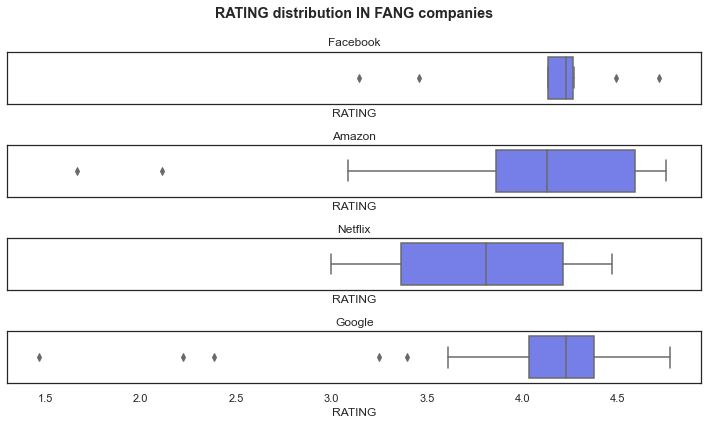

In [44]:
fig, axes = plt.subplots(4, 1, figsize = (10, 6), sharex = True)
x = 0
for i in FANG:
    sb.boxplot(data = i, x = "RATING", ax = axes[x], color = '#636efa')
    x += 1
x = 0 #reset
for i in stringFANG:
    axes[x].set_title(i)
    x += 1
x = 0 #reset

fig.suptitle('RATING distribution IN FANG companies',fontweight ="bold")
plt.tight_layout()


Facebook's apps have the most concentrated distribution of ratings while Netflix's apps have the lowest median. <br>
Amazon and Google both have one app each with rating lower than two, let's take a look at what apps could it be.

### What kind of apps do such great company develop?

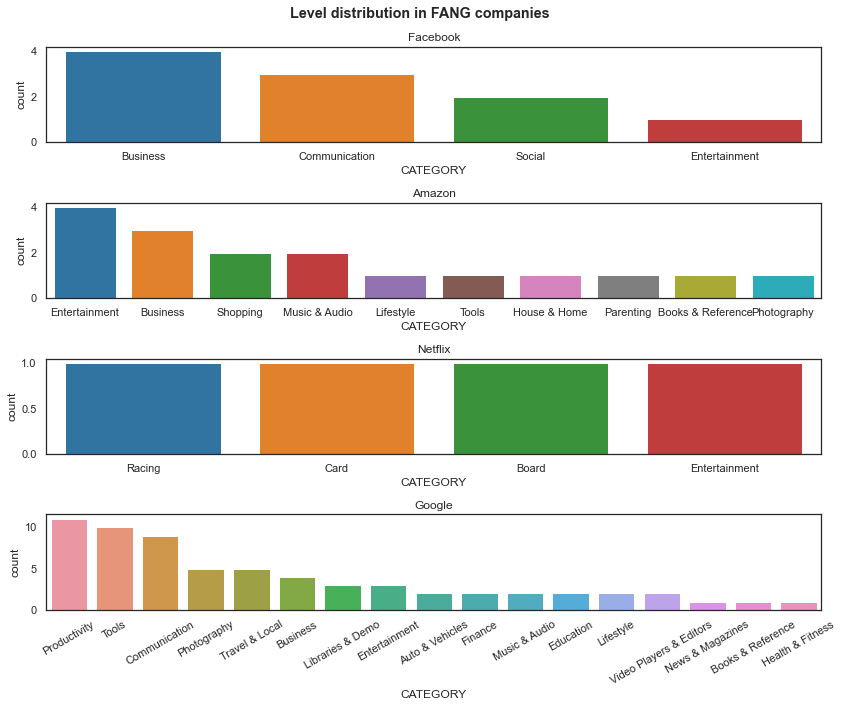

In [45]:
fig, axes = plt.subplots(4, 1, figsize = (12, 10))
x = 0
for i in FANG:
    sb.countplot(x = "CATEGORY", data = i, ax = axes[x] , order = i["CATEGORY"].value_counts().index)
    if (x == 3):
        plt.xticks(rotation = 30)
    x += 1
x = 0 #reset
for i in stringFANG:
    axes[x].set_title(i)
    x += 1
x = 0 #reset
fig.suptitle('Level distribution in FANG companies',fontweight ="bold")
plt.tight_layout()


The first three plots here is a little unintuitive and not expected. <br>
Facebook is well known for social media apps, but it shows that the mode category is business.<br>
Amazon is well known for its shopping platform, but here the mode category is entertainment. <br>
On the other hand, Netflix is well known for movies and series entertainment, but game is the most developed app here.<br>
Maybe we should try plotting this from a different perspective.

### Let's find out how each category did in each company, shall we?

Text(0.5, 1.04, 'Max Installs VS Category of Apps Developed by FANG')

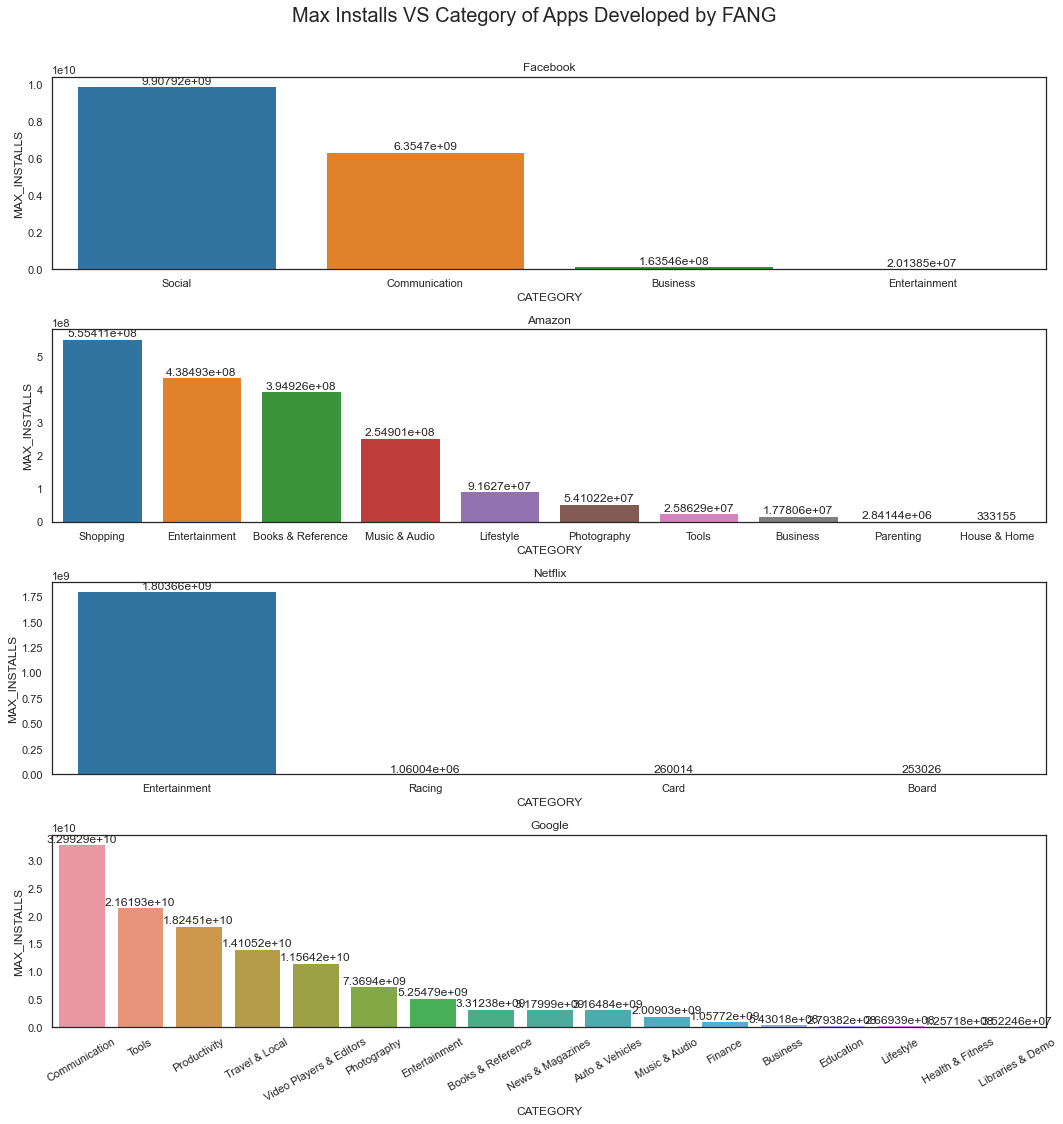

In [46]:
fb2 = facebook_apps.groupby(['CATEGORY'])['MAX_INSTALLS'].sum().reset_index()
amz2 = amazon_apps.groupby(['CATEGORY'])['MAX_INSTALLS'].sum().reset_index()
net2 = netflix_apps.groupby(['CATEGORY'])['MAX_INSTALLS'].sum().reset_index()
goog2 = google_apps.groupby(['CATEGORY'])['MAX_INSTALLS'].sum().reset_index()
FANG2 = [fb2, amz2, net2, goog2]

fig, axes = plt.subplots(4, 1, figsize = (15, 15))
x = 0
for i in FANG2:
    ax = sb.barplot(x = "CATEGORY", y = 'MAX_INSTALLS', data = i, ax = axes[x] , order = i.sort_values('MAX_INSTALLS', ascending = False).CATEGORY)
    ax.bar_label(ax.containers[0])
    if (x == 3):
        plt.xticks(rotation = 30)
    x += 1
x = 0 #reset
for i in stringFANG:
    axes[x].set_title(i)
    x += 1
x = 0 #reset
plt.tight_layout()
plt.suptitle("Max Installs VS Category of Apps Developed by FANG", y = 1.04, size = 20)

These plots are much more intuitive now. <br>
In fact, Facebook's most well-known app falls under the 'Social' category because Facebook is a social media platform. <br>
And Amazon is a e-shopping platform while Netflix is an entertainment platform.<br>Google is the leading platform in tools, productivity and communication.

<a id ='geospatial analysis'></a>
## Geospatial Analysis
We will use the same dataset but will drop those rows without values in the COUNTRY column.

In [47]:
df_country = df_cleaned.dropna(subset=['COUNTRY'])
df_country.reset_index(drop= True, inplace=True)
df_country.shape

(11588, 24)

In [48]:
df_country[df_country["COUNTRY"] == "Luxembourg"]

APP_NAME    RATING       CATEGORY  RATING_COUNT  \
561           Applaydu family games  4.362205    Educational         62604   
655    Audio Memos - Voice Recorder  3.722222   Productivity            62   
1465        CDisplayEx Comic Reader  4.710000         Comics          3318   
1466   CDisplayEx Free Comic Reader  4.400000         Comics          8969   
8679                          Skype  4.132845  Communication      11442600   
10424  Viber - Safe Chats And Calls  4.462056  Communication      15699977   

       1_STAR_RATINGS  2_STAR_RATINGS  3_STAR_RATINGS  4_STAR_RATINGS  \
561              5922            1940            3433            3433   
655                 7              10               3              14   
1465               61               0              61             566   
1466              538             448             179            1525   
8679          1529613          400685          670410         1261164   
10424         1002545          329033          777517         1893357   

       5_STAR_RATINGS  REVIEW_COUNT        INSTALLS  MAX_INSTALLS   FREE  \
561             47876         467.0     10,000,000+      17342886   True   
655                28          11.0          5,000+          5181  False   
1465             2630         264.0         10,000+         30466  False   
1466             6279         166.0        500,000+        545630   True   
8679          7580728      419372.0  1,000,000,000+    1874038869   True   
10424        11697525      399642.0  1,000,000,000+    1035500126   True   

       PRICE          SIZE                 DEVELOPER  \
561     0.00  1.400000e+09  Ferrero Trading Lux S.A.   
655     0.99  4.700000e+07          Imesart S.a.r.l.   
1465    5.99  4.700000e+07         Progdigy Software   
1466    0.00  4.700000e+07         Progdigy Software   
8679    0.00  4.700000e+07                     Skype   
10424   0.00  4.700000e+07      Viber Media S.à r.l.   

                                       DEVELOPER_ADDRESS     COUNTRY  \
561    Ferrero Trading Lux S.A.\r\n16, rue de Trèves\...  Luxembourg   
655       rue du Kiem 130\r\n8030 Strassen\r\nLuxembourg  Luxembourg   
1465   55 rue de la Libération\r\nL3511 Dudelange\r\n...  Luxembourg   
1466   55 rue de la Libération\r\nL3511 Dudelange\r\n...  Luxembourg   
8679   Skype Software S.à.r.l, 23 – 29 Rives de Claus...  Luxembourg   
10424  Viber Media, S.à r.l.,\r\n2, rue des Fossé, L-...  Luxembourg   

      CONTENT_RATING  AD_SUPPORTED  IN_APP_PURCHASES  EDITORS_CHOICE  \
561         Everyone         False             False           False   
655         Everyone         False              True           False   
1465        Everyone         False             False           False   
1466        Everyone          True             False           False   
8679        Everyone         False              True            True   
10424       Everyone          True              True           False   

       DAYS_SINCE_UPDATE  DAYS_SINCE_RELEASED  
561                  8.0                449.0  
655                511.0               3333.0  
1465               348.0               1423.0  
1466               383.0               1423.0  
8679                 7.0               4173.0  
10424                5.0               3885.0

### 1. Comparing the average of max installs of the apps developed by each country.

In [49]:
max_installs_by_mean = pd.DataFrame(df_country.groupby(["COUNTRY"])["MAX_INSTALLS"].agg("mean"))
max_installs_by_mean.rename(columns={'MAX_INSTALLS': 'MEAN_MAX_INSTALLS'}, inplace = True)
max_installs_by_mean = max_installs_by_mean.nlargest(10,['MEAN_MAX_INSTALLS'])
max_installs_by_mean = max_installs_by_mean.reset_index()
max_installs_by_mean

COUNTRY  MEAN_MAX_INSTALLS
0   Luxembourg       4.879105e+08
1         Oman       6.050167e+07
2      Finland       6.021174e+07
3  South Korea       5.321177e+07
4    Singapore       5.044285e+07
5          Usa       4.926557e+07
6      Denmark       4.643689e+07
7       Norway       3.377678e+07
8      Ireland       2.922904e+07
9       Cyprus       2.620449e+07

In [50]:
sequence = []
for i in range (1000,0,-100):
    sequence.append(i)
max_installs_by_mean['SIZE'] = sequence
max_installs_by_mean
max_installs_by_mean

COUNTRY  MEAN_MAX_INSTALLS  SIZE
0   Luxembourg       4.879105e+08  1000
1         Oman       6.050167e+07   900
2      Finland       6.021174e+07   800
3  South Korea       5.321177e+07   700
4    Singapore       5.044285e+07   600
5          Usa       4.926557e+07   500
6      Denmark       4.643689e+07   400
7       Norway       3.377678e+07   300
8      Ireland       2.922904e+07   200
9       Cyprus       2.620449e+07   100

In [51]:
fig = px.bar(max_installs_by_mean, x='COUNTRY', y='MEAN_MAX_INSTALLS')
fig.update_layout(
    width=600,
    height=500,
    title='MEAN_MAX_INSTALLS VS COUNTRY'
)
fig.show()

We have grouped the dataset by country and find their mean of max installs per country. Then we will proceed with picking the top 10 countries. <br>
Usa, South Korea, Singapore, France, Finland, China, Turkey and Hong Kong all remains on the list.

In [52]:
fig = px.scatter_geo(max_installs_by_mean, locations="COUNTRY", 
                     hover_name="COUNTRY", size = 'MEAN_MAX_INSTALLS',locationmode = 'country names')
fig.update_layout({
    'geo': {
        'resolution': 50
    }
})
fig.show()

### 2. Comparing the average rating of the apps developed by each country.
We will do the same thing, but this time we will explore on the rating.

In [53]:
rating_by_mean = pd.DataFrame(df_country.groupby(["COUNTRY"])["RATING"].agg("mean"))
rating_by_mean.rename(columns={'RATING': 'MEAN_RATING'}, inplace = True)

In [54]:
fig = px.box(rating_by_mean, x = "MEAN_RATING",points="all")
fig.update_layout(
    width=600,
    height=500,
    title='MEAN_RATING DISTRIBUTION'
)
fig.show()

This figure gives us 2 types of visualizations, boxplot and swarmplot. Which provide us an insight where the majority of data lies in the rating spectrum. Which is 4 to 4.5. <br>
Notice there's a few outliers that have rating that are lower than 3.5. Let's find out which countries are those.

In [55]:
lowest_mean_rating = rating_by_mean[rating_by_mean['MEAN_RATING'] < 3.5]
lowest_mean_rating

MEAN_RATING
COUNTRY             
Belize      3.288830
Iceland     3.462838
Uganda      2.200000

In [56]:
rating_by_mean = rating_by_mean.nlargest(10,['MEAN_RATING'])
rating_by_mean = rating_by_mean.reset_index()
rating_by_mean

COUNTRY  MEAN_RATING
0  Montenegro     4.800969
1   Venezuela     4.670000
2     Albania     4.633178
3  Costa Rica     4.566433
4     Andorra     4.549720
5       Nepal     4.540000
6     Uruguay     4.539158
7        Peru     4.535119
8    Tanzania     4.527273
9       Ghana     4.511662

In [57]:
fig = px.bar(rating_by_mean, x='COUNTRY', y='MEAN_RATING')
fig.update_layout(
    width=600,
    height=500,
    title='MEAN_RATING VS COUNTRY'
)
fig.show()

In [58]:
rating_by_mean = rating_by_mean.nlargest(10,['MEAN_RATING'])
sequence = []
for i in range (1000,0,-100):
    sequence.append(i)
rating_by_mean['SIZE'] = sequence
rating_by_mean


COUNTRY  MEAN_RATING  SIZE
0  Montenegro     4.800969  1000
1   Venezuela     4.670000   900
2     Albania     4.633178   800
3  Costa Rica     4.566433   700
4     Andorra     4.549720   600
5       Nepal     4.540000   500
6     Uruguay     4.539158   400
7        Peru     4.535119   300
8    Tanzania     4.527273   200
9       Ghana     4.511662   100

In [59]:
fig = px.scatter_geo(rating_by_mean, locations="COUNTRY", 
                     hover_name="COUNTRY", hover_data=["MEAN_RATING"], size = 'SIZE',locationmode = 'country names')
fig.update_layout({
    'geo': {
        'resolution': 50
    }
})
fig.show()

Compared to the previous map, this map's bubbles are more consistent and we can clearly see which bubble is bigger. Because we introduced a rank metric called SIZE which will change the bubble size according the ranking of the country instead of the mean ratings. 

### References
- http://shakedzy.xyz/dython/